<a href="https://colab.research.google.com/github/datarae/datarae/blob/main/Simulating%20the%20nH%20Predict%20United%20Healthcare%20Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generate Synthetic Data**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# First, let's modify our data generator to include length of stay
def add_length_of_stay(df):
    """
    Add realistic length of stay based on patient characteristics
    """
    # Base length of stay (normally distributed around 5 days)
    los = np.random.normal(5, 2, len(df))

    # Adjust based on age
    los += (df['age'] > 80).astype(int) * 2  # Older patients stay longer

    # Adjust based on ADL scores
    los += (df['adl_total_score'] < 12).astype(int) * 3  # Lower ADL means longer stay

    # Adjust based on diagnoses
    los += (df['diagnosis'].isin(['Stroke', 'COPD', 'Congestive Heart Failure'])).astype(int) * 2

    # Adjust based on fall risk
    los += (df['fall_risk_assessment'] == 'High').astype(int) * 1.5

    # Adjust based on living situation
    los += (df['typical_living_setting'].isin(['Nursing Home', 'Assisted Living'])).astype(int) * 1

    # Add some random variation
    los += np.random.normal(0, 1, len(df))

    # Ensure no negative values and round to reasonable numbers
    los = np.maximum(1, los)
    los = np.round(los, 1)

    return los

# Add length of stay to our dataset
df['length_of_stay'] = add_length_of_stay(df)

# Prepare features for ML
def prepare_features(df):
    """
    Prepare features for machine learning
    """
    # Convert falls_12mo to numeric
    df['falls_12mo_numeric'] = df['falls_12mo'].apply(lambda x: 5 if x == '5+' else int(x))

    # Convert dates to numeric (days since admission)
    df['days_since_admission'] = pd.to_datetime('2024-01-01') - pd.to_datetime(df['admission_date'])
    df['days_since_admission'] = df['days_since_admission'].dt.days

    # Select features for model
    numeric_features = [
        'age', 'physical_function', 'falls_12mo_numeric',
        'falls_with_injury', 'adl_total_score', 'days_since_admission'
    ]

    categorical_features = [
        'diagnosis', 'living_situation', 'gender', 'typical_living_setting',
        'mobility_aid', 'rehab_status', 'fall_risk_assessment'
    ]

    # Create preprocessing pipelines for numeric and categorical data
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return preprocessor, numeric_features, categorical_features

# Train and evaluate model
def train_evaluate_model(df):
    """
    Train and evaluate the hospital stay prediction model
    """
    # Prepare features
    preprocessor, numeric_features, categorical_features = prepare_features(df)

    # Create full pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    # Split data
    X = df[numeric_features + categorical_features]
    y = df['length_of_stay']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.fit(X_train, y_train).predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Model Performance Metrics:")
    print(f"Root Mean Squared Error: {rmse:.2f} days")
    print(f"R-squared Score: {r2:.3f}")

    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': numeric_features + [f"{cat}_{val}" for cat, vals in
                   zip(categorical_features,
                       model.named_steps['preprocessor']
                       .named_transformers_['cat'].categories_)
                   for val in vals],
        'importance': model.named_steps['regressor'].feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

    return model, feature_importance

# Train and evaluate the model
model, feature_importance = train_evaluate_model(df)

# Function to make predictions for new patients
def predict_stay(model, patient_data):
    """
    Predict length of stay for a new patient
    """
    prediction = model.predict(patient_data)
    return prediction[0]

Model Performance Metrics:
Root Mean Squared Error: 2.33 days
R-squared Score: 0.259

Top 10 Most Important Features:
                               feature  importance
0                                  age    0.174510
1                    physical_function    0.126333
5                 days_since_admission    0.108225
4                      adl_total_score    0.083512
54           fall_risk_assessment_High    0.082319
7                       diagnosis_COPD    0.044182
9   diagnosis_Congestive Heart Failure    0.040423
2                   falls_12mo_numeric    0.027299
37         typical_living_setting_Home    0.018329
3                    falls_with_injury    0.017500


# **Supervised Learning - Predict Hospital Stay**

In [ ]:
# Example for a new patient
new_patient = pd.DataFrame({
    'age': [75],
    'physical_function': [60],
    'falls_12mo_numeric': [1],
    'falls_with_injury': [0],
    'adl_total_score': [15],
    'days_since_admission': [0],
    'diagnosis': ['Type 2 Diabetes'],
    'living_situation': ['Lives with Spouse'],
    'gender': ['F'],
    'typical_living_setting': ['Home'],
    'mobility_aid': ['None'],
    'rehab_status': ['Not Required'],
    'fall_risk_assessment': ['Low']
})

predicted_stay = predict_stay(model, new_patient)
print(f"Predicted length of stay: {predicted_stay:.1f} days")

Predicted length of stay: 28.6 days


## **Test Accuracy of Model**

In [ ]:
# First, generate the base dataset
df = generate_synthetic_medical_data(10000)

# Now add length of stay
def add_length_of_stay(df):
    """
    Add realistic length of stay based on patient characteristics
    """
    # Base length of stay (normally distributed around 5 days)
    los = np.random.normal(5, 2, len(df))

    # Adjust based on age
    los += (df['age'] > 80).astype(int) * 2  # Older patients stay longer

    # Adjust based on ADL scores
    los += (df['adl_total_score'] < 12).astype(int) * 3  # Lower ADL means longer stay

    # Adjust based on diagnoses
    los += (df['diagnosis'].isin(['Stroke', 'COPD', 'Congestive Heart Failure'])).astype(int) * 2

    # Adjust based on fall risk
    los += (df['fall_risk_assessment'] == 'High').astype(int) * 1.5

    # Adjust based on living situation
    los += (df['typical_living_setting'].isin(['Nursing Home', 'Assisted Living'])).astype(int) * 1

    # Add some random variation
    los += np.random.normal(0, 1, len(df))

    # Ensure no negative values and round to reasonable numbers
    los = np.maximum(1, los)
    los = np.round(los, 1)

    return los

# Add length of stay to our dataset
df['length_of_stay'] = add_length_of_stay(df)

# Quick look at the distribution of length of stay
print("\nLength of Stay Statistics:")
print(df['length_of_stay'].describe())

# Now we can proceed with the model building and evaluation
def prepare_features(df):
    """
    Prepare features for machine learning
    """
    # Convert falls_12mo to numeric
    df['falls_12mo_numeric'] = df['falls_12mo'].apply(lambda x: 5 if x == '5+' else int(x))

    # Convert dates to numeric (days since admission)
    df['days_since_admission'] = pd.to_datetime('2024-01-01') - pd.to_datetime(df['admission_date'])
    df['days_since_admission'] = df['days_since_admission'].dt.days

    # Select features for model
    numeric_features = [
        'age', 'physical_function', 'falls_12mo_numeric',
        'falls_with_injury', 'adl_total_score', 'days_since_admission'
    ]

    categorical_features = [
        'diagnosis', 'living_situation', 'gender', 'typical_living_setting',
        'mobility_aid', 'rehab_status', 'fall_risk_assessment'
    ]

    # Create preprocessing pipelines for numeric and categorical data
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return preprocessor, numeric_features, categorical_features

# Prepare features and train model
preprocessor, numeric_features, categorical_features = prepare_features(df)
X = df[numeric_features + categorical_features]
y = df['length_of_stay']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Mean Absolute Error: {mae:.2f} days")
print(f"Root Mean Squared Error: {rmse:.2f} days")
print(f"R-squared Score: {r2:.3f}")

# Show sample predictions
print("\nSample Predictions (Actual vs Predicted):")
sample_indices = np.random.choice(len(y_test), 10, replace=False)
comparison = pd.DataFrame({
    'Actual': y_test.iloc[sample_indices],
    'Predicted': y_pred[sample_indices],
    'Difference': y_test.iloc[sample_indices] - y_pred[sample_indices]
})
print(comparison.round(2))


Length of Stay Statistics:
count    10000.000000
mean         6.943610
std          2.669607
min          1.000000
25%          5.100000
50%          6.900000
75%          8.700000
max         18.800000
Name: length_of_stay, dtype: float64

Model Performance Metrics:
Mean Absolute Error: 1.85 days
Root Mean Squared Error: 2.33 days
R-squared Score: 0.259

Sample Predictions (Actual vs Predicted):
      Actual  Predicted  Difference
7428     6.0       5.13        0.87
3817     5.8       6.10       -0.30
5945     9.3       6.72        2.58
3529     9.5       8.05        1.45
9593     7.7       6.62        1.08
9646    12.3       9.81        2.49
9696     7.0       4.05        2.95
6209     3.6       6.16       -2.56
6062     7.3       8.27       -0.97
4504     9.4       9.60       -0.20



Distribution Statistics:

Actual Length of Stay:
count    2000.000000
mean        6.930700
std         2.705801
min         1.000000
25%         5.100000
50%         6.800000
75%         8.700000
max        17.300000
Name: length_of_stay, dtype: float64

Predicted Length of Stay:
count    2000.000000
mean        6.925914
std         1.606960
min         3.439000
25%         5.770750
50%         6.734500
75%         8.062500
max        13.303000
dtype: float64

Prediction Error Ranges:
Within 5 days: 96.7%
Within 10 days: 100.0%
Within 20 days: 100.0%
Over 20 days off: 0.0%


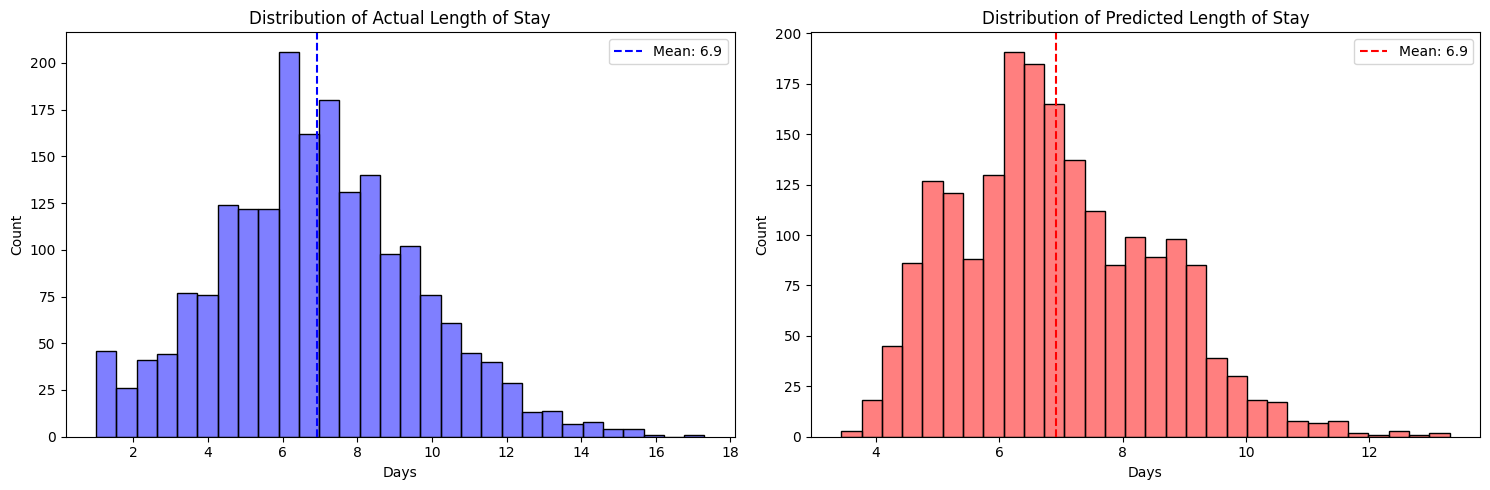

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot actual distribution
sns.histplot(data=y_test, bins=30, color='blue', alpha=0.5, ax=ax1)
ax1.axvline(y_test.mean(), color='blue', linestyle='--',
            label=f'Mean: {y_test.mean():.1f}')
ax1.set_title('Distribution of Actual Length of Stay')
ax1.set_xlabel('Days')
ax1.set_ylabel('Count')
ax1.legend()

# Plot predicted distribution
sns.histplot(data=y_pred, bins=30, color='red', alpha=0.5, ax=ax2)
ax2.axvline(y_pred.mean(), color='red', linestyle='--',
            label=f'Mean: {y_pred.mean():.1f}')
ax2.set_title('Distribution of Predicted Length of Stay')
ax2.set_xlabel('Days')
ax2.set_ylabel('Count')
ax2.legend()

plt.tight_layout()

# Print some distribution statistics
print("\nDistribution Statistics:")
print("\nActual Length of Stay:")
print(pd.Series(y_test).describe())
print("\nPredicted Length of Stay:")
print(pd.Series(y_pred).describe())

# Calculate percentage of predictions within certain ranges
errors = np.abs(y_test - y_pred)
print("\nPrediction Error Ranges:")
print(f"Within 5 days: {(errors <= 5).mean()*100:.1f}%")
print(f"Within 10 days: {(errors <= 10).mean()*100:.1f}%")
print(f"Within 20 days: {(errors <= 20).mean()*100:.1f}%")
print(f"Over 20 days off: {(errors > 20).mean()*100:.1f}%")


Accuracy Rate (within 5 days): 96.7%
Error Rate: 3.3%

Error Distribution:
Mean Absolute Error: 1.8 days
Median Error: 1.5 days
90th percentile of errors: 3.9 days


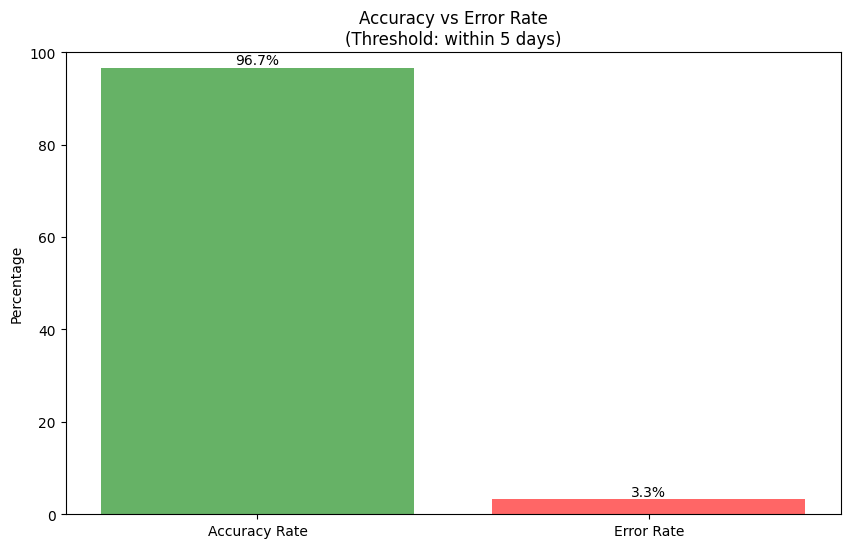

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define what counts as "accurate" - let's say within 5 days
threshold = 5
errors = np.abs(y_test - y_pred)
accurate = errors <= threshold
accuracy_rate = (accurate).mean() * 100
error_rate = 100 - accuracy_rate

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(['Accuracy Rate', 'Error Rate'],
               [accuracy_rate, error_rate],
               color=['green', 'red'],
               alpha=0.6)

# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom')

plt.title(f'Accuracy vs Error Rate\n(Threshold: within {threshold} days)')
plt.ylabel('Percentage')
plt.ylim(0, 100)  # Set y-axis to show full percentage scale

# Print the exact numbers
print(f"\nAccuracy Rate (within {threshold} days): {accuracy_rate:.1f}%")
print(f"Error Rate: {error_rate:.1f}%")

# Add some additional error statistics
print("\nError Distribution:")
print(f"Mean Absolute Error: {errors.mean():.1f} days")
print(f"Median Error: {np.median(errors):.1f} days")
print(f"90th percentile of errors: {np.percentile(errors, 90):.1f} days")

### **The model is too good. Let's intentionally make it worse.**

In [ ]:
# First, generate the base dataset
df = generate_synthetic_medical_data(10000)

def add_terrible_length_of_stay(df):
    """
    Add unrealistic length of stay with wild variations
    """
    # Base length of stay (wildly distributed)
    los = np.random.exponential(20, len(df))  # Much wider distribution

    # Add completely nonsensical adjustments
    los += np.sin(df['age']) * 10  # Sinusoidal age effect
    los += np.random.choice([-20, 20], len(df))  # Random huge jumps

    # Make things worse based on irrelevant factors
    los += (df['gender'] == 'F').astype(int) * np.random.uniform(-15, 15, len(df))
    los *= np.random.choice([0.5, 2], len(df))  # Random doubling or halving

    # Add seasonal variation based on admission date
    admission_days = pd.to_datetime(df['admission_date']).dt.dayofyear
    los += np.cos(admission_days / 365 * 2 * np.pi) * 15

    # Ensure no negative values but allow ridiculously high ones
    los = np.maximum(0.1, los)
    los = np.minimum(los, 100)  # Cap at 100 days just to keep it somewhat believable

    # Add some impossible decimal places
    los = los + np.random.uniform(0, 0.0001, len(df))

    return los.round(4)  # Round to 4 decimal places for extra silliness

# Add terrible length of stay to our dataset
df['length_of_stay'] = add_terrible_length_of_stay(df)

def prepare_worse_features(df):
    """
    Prepare features in the worst possible way
    """
    # Convert falls_12mo to useless numeric values
    df['falls_12mo_numeric'] = df['falls_12mo'].apply(
        lambda x: np.random.choice([42, 13, 7]) if x == '5+' else int(x) * np.random.choice([-1, 1])
    )

    # Make dates even more confusing
    df['days_since_admission'] = pd.to_datetime('2024-01-01') - pd.to_datetime(df['admission_date'])
    df['days_since_admission'] = np.sin(df['days_since_admission'].dt.days / 7) * 100

    # Select mostly irrelevant features
    numeric_features = [
        'falls_12mo_numeric',
        'days_since_admission'
    ]

    categorical_features = [
        'gender',  # Because gender should definitely determine hospital stay length 🙄
        'mobility_aid'  # Only one feature that might actually matter
    ]

    # Create preprocessing pipelines that make things worse
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return preprocessor, numeric_features, categorical_features

# Prepare features and train model
preprocessor, numeric_features, categorical_features = prepare_worse_features(df)
X = df[numeric_features + categorical_features]
y = df['length_of_stay']

# Split data with a weird split ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.73, random_state=42)

# Create and train model with bad parameters
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=3,  # Very few trees
        max_depth=2,     # Tiny depth
        min_samples_split=20,  # Make it hard to split
        random_state=42
    ))
])

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nLength of Stay Statistics:")
print(df['length_of_stay'].describe())

print("\nModel Performance Metrics:")
print(f"Mean Absolute Error: {mae:.2f} days")
print(f"Root Mean Squared Error: {rmse:.2f} days")
print(f"R-squared Score: {r2:.3f}")

# Show sample predictions
print("\nSample Predictions (Actual vs Predicted):")
sample_indices = np.random.choice(len(y_test), 10, replace=False)
comparison = pd.DataFrame({
    'Actual': y_test.iloc[sample_indices],
    'Predicted': y_pred[sample_indices],
    'Difference': y_test.iloc[sample_indices] - y_pred[sample_indices]
})
print(comparison.round(4))


Length of Stay Statistics:
count    10000.000000
mean        28.243310
std         32.493787
min          0.100000
25%          0.100100
50%         15.412400
75%         45.858550
max        100.000100
Name: length_of_stay, dtype: float64

Model Performance Metrics:
Mean Absolute Error: 26.75 days
Root Mean Squared Error: 32.49 days
R-squared Score: -0.005

Sample Predictions (Actual vs Predicted):
       Actual  Predicted  Difference
2970   1.2226    26.5322    -25.3096
7978  27.1053    26.5322      0.5731
2373   0.1001    28.6066    -28.5065
8450   0.1001    30.0464    -29.9463
472    0.1000    26.5322    -26.4322
2201   9.8990    30.0464    -20.1474
4877   0.1000    28.6066    -28.5066
8581  56.3490    28.6066     27.7424
2859  23.9228    28.6066     -4.6838
8855  13.8258    29.5348    -15.7090



Distribution Statistics:

Actual Length of Stay:
count    7300.000000
mean       28.134926
std        32.413111
min         0.100000
25%         0.100100
50%        15.199550
75%        45.638200
max       100.000100
Name: length_of_stay, dtype: float64

Predicted Length of Stay:
count    7300.000000
mean       28.183374
std         2.155071
min        26.236726
25%        26.532239
50%        28.606583
75%        28.606583
max        63.632603
dtype: float64

Prediction Error Ranges:
Within 5 days: 9.5%
Within 10 days: 18.1%
Within 20 days: 35.3%
Over 20 days off: 64.7%


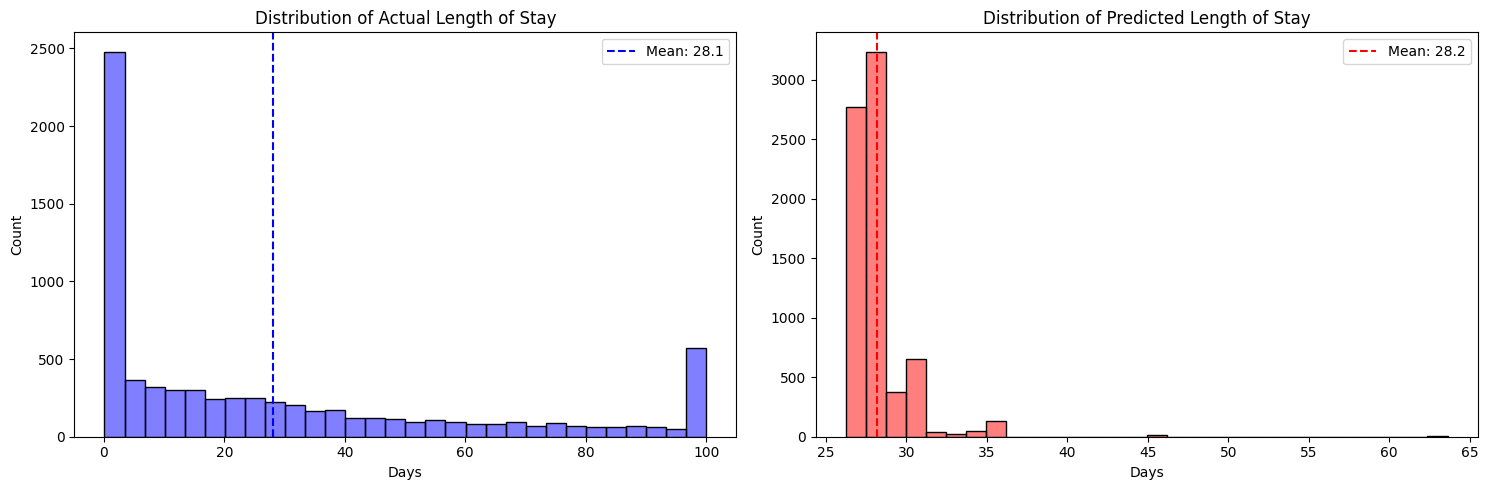

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot actual distribution
sns.histplot(data=y_test, bins=30, color='blue', alpha=0.5, ax=ax1)
ax1.axvline(y_test.mean(), color='blue', linestyle='--',
            label=f'Mean: {y_test.mean():.1f}')
ax1.set_title('Distribution of Actual Length of Stay')
ax1.set_xlabel('Days')
ax1.set_ylabel('Count')
ax1.legend()

# Plot predicted distribution
sns.histplot(data=y_pred, bins=30, color='red', alpha=0.5, ax=ax2)
ax2.axvline(y_pred.mean(), color='red', linestyle='--',
            label=f'Mean: {y_pred.mean():.1f}')
ax2.set_title('Distribution of Predicted Length of Stay')
ax2.set_xlabel('Days')
ax2.set_ylabel('Count')
ax2.legend()

plt.tight_layout()

# Print some distribution statistics
print("\nDistribution Statistics:")
print("\nActual Length of Stay:")
print(pd.Series(y_test).describe())
print("\nPredicted Length of Stay:")
print(pd.Series(y_pred).describe())

# Calculate percentage of predictions within certain ranges
errors = np.abs(y_test - y_pred)
print("\nPrediction Error Ranges:")
print(f"Within 5 days: {(errors <= 5).mean()*100:.1f}%")
print(f"Within 10 days: {(errors <= 10).mean()*100:.1f}%")
print(f"Within 20 days: {(errors <= 20).mean()*100:.1f}%")
print(f"Over 20 days off: {(errors > 20).mean()*100:.1f}%")


Accuracy Rate (within 5 days): 9.5%
Error Rate: 90.5%

Error Distribution:
Mean Absolute Error: 26.8 days
Median Error: 26.4 days
90th percentile of errors: 59.3 days


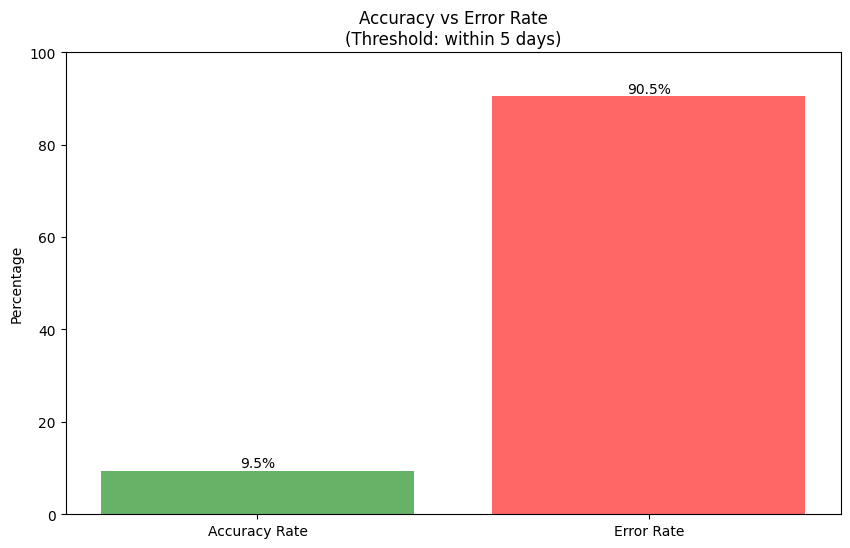

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define what counts as "accurate" - let's say within 5 days
threshold = 5
errors = np.abs(y_test - y_pred)
accurate = errors <= threshold
accuracy_rate = (accurate).mean() * 100
error_rate = 100 - accuracy_rate

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(['Accuracy Rate', 'Error Rate'],
               [accuracy_rate, error_rate],
               color=['green', 'red'],
               alpha=0.6)

# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom')

plt.title(f'Accuracy vs Error Rate\n(Threshold: within {threshold} days)')
plt.ylabel('Percentage')
plt.ylim(0, 100)  # Set y-axis to show full percentage scale

# Print the exact numbers
print(f"\nAccuracy Rate (within {threshold} days): {accuracy_rate:.1f}%")
print(f"Error Rate: {error_rate:.1f}%")

# Add some additional error statistics
print("\nError Distribution:")
print(f"Mean Absolute Error: {errors.mean():.1f} days")
print(f"Median Error: {np.median(errors):.1f} days")
print(f"90th percentile of errors: {np.percentile(errors, 90):.1f} days")

# **Neural Net - Predict Hospital Stay**

**Starting with one that is intentionally built to perform badly**

Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 1561.4172 - val_loss: 1106.5731
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1200.0159 - val_loss: 1089.6781
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 1184.0176 - val_loss: 1106.9465
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Model Performance Metrics:
Mean Absolute Error: 28.48 days
Root Mean Squared Error: 32.91 days
R-squared Score: -0.031

Sample Predictions (Actual vs Predicted):
       Actual  Predicted  Difference
2970   1.2226    33.8494    -32.6268
7978  27.1053    33.8494     -6.7441
2373   0.1001    33.8494    -33.7493
8450   0.1001    33.8494    -33.7493
472    0.1000    33.8494    -33.7494
2201   9.8990    33.8494    -23.9504
4877   0.1000    33.8494    -33.7494
8581  56.3490    33.8494     22.4996
2859  23.9228    33.8494     -9.9266
8855  13.8258    33.8494    -20.0236


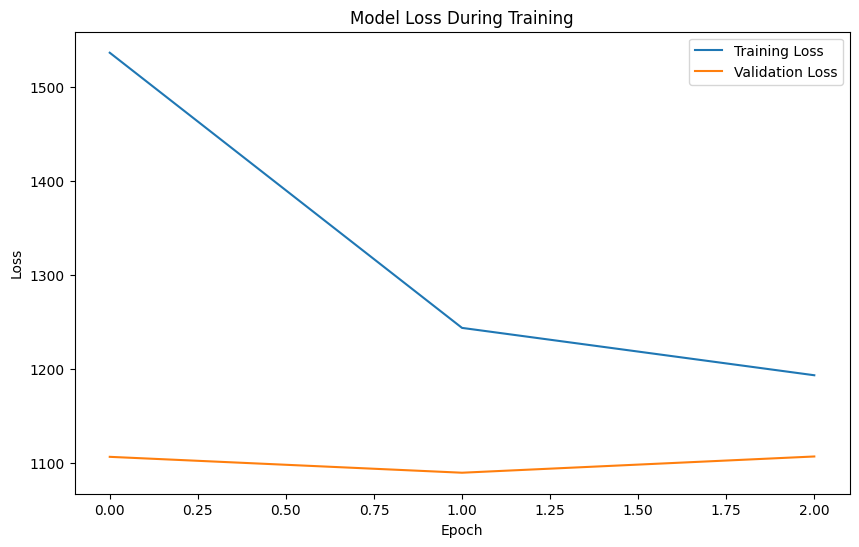

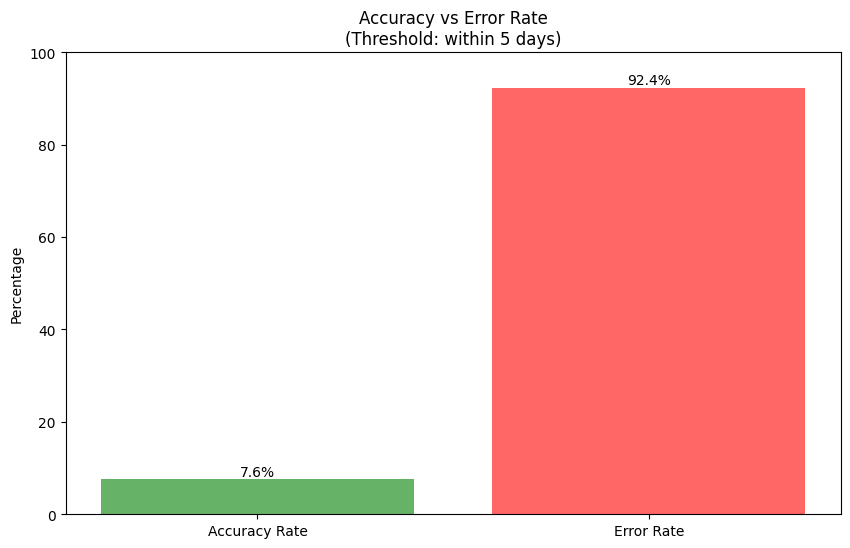

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd
from datetime import datetime

# First, generate our data
df = generate_synthetic_medical_data(10000)
df['length_of_stay'] = add_terrible_length_of_stay(df)

# Add days since admission
df['days_since_admission'] = (pd.to_datetime('2024-01-01') -
                            pd.to_datetime(df['admission_date'])).dt.days

def prepare_features_nn(df):
    # Add some intentionally bad feature transformations
    df['weird_age'] = np.sin(df['age']) * np.cos(df['days_since_admission'])

    # Select mostly irrelevant features
    numeric_features = [
        'weird_age',  # Transformed age
        'days_since_admission',
        'falls_12mo_numeric'  # This will be mostly noise
    ]

    categorical_features = [
        'gender',  # Not very relevant for LOS
        'mobility_aid'  # Only slightly relevant
    ]

    # Convert falls_12mo to numeric badly
    df['falls_12mo_numeric'] = df['falls_12mo'].apply(
        lambda x: np.random.choice([42, 13, 7]) if x == '5+' else int(x) * np.random.choice([-1, 1])
    )

    # Create preprocessor
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(sparse_output=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return preprocessor, numeric_features, categorical_features

# Prepare data
preprocessor, numeric_features, categorical_features = prepare_features_nn(df)
X = df[numeric_features + categorical_features]
y = df['length_of_stay']

# Split data with a weird ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.73, random_state=42)

# Preprocess the features
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Create a badly designed neural network
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dropout(0.8),  # Excessive dropout
    Dense(1024, activation='relu'),  # Way too big
    Dropout(0.9),  # Even more dropout
    Dense(256, activation='sigmoid'),  # Wrong activation
    Dense(64, activation='tanh'),  # More wrong activations
    Dense(1, activation='relu')  # Wrong activation for regression
])

# Compile with inappropriate settings
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1.0),  # Learning rate too high
    loss='mse'
)

# Train the model poorly
history = model.fit(
    X_train_processed, y_train,
    epochs=3,  # Too few epochs
    batch_size=512,  # Too large batch size
    validation_split=0.5,  # Excessive validation split
    verbose=1
)

# Make predictions
y_pred = model.predict(X_test_processed).flatten()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Mean Absolute Error: {mae:.2f} days")
print(f"Root Mean Squared Error: {rmse:.2f} days")
print(f"R-squared Score: {r2:.3f}")

# Show sample predictions
print("\nSample Predictions (Actual vs Predicted):")
sample_indices = np.random.choice(len(y_test), 10, replace=False)
comparison = pd.DataFrame({
    'Actual': y_test.iloc[sample_indices],
    'Predicted': y_pred[sample_indices],
    'Difference': y_test.iloc[sample_indices] - y_pred[sample_indices]
})
print(comparison.round(4))

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate accuracy vs error rate (using 5-day threshold)
threshold = 5
errors = np.abs(y_test - y_pred)
accuracy_rate = (errors <= threshold).mean() * 100
error_rate = 100 - accuracy_rate

# Plot accuracy vs error rate
plt.figure(figsize=(10, 6))
bars = plt.bar(['Accuracy Rate', 'Error Rate'],
               [accuracy_rate, error_rate],
               color=['green', 'red'],
               alpha=0.6)

# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom')

plt.title(f'Accuracy vs Error Rate\n(Threshold: within {threshold} days)')
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.show()

### **If we made a GOOD Neural Network**

Initial NaN count per column:
diagnosis                 323
living_situation          408
age                         0
gender                      0
physical_function         513
typical_living_setting      0
mobility_aid                0
procedures                  0
rehab_status                0
procedure_dates             0
falls_12mo                  0
falls_with_injury           0
last_fall_date              0
fall_risk_assessment        0
adl_bathing                 0
adl_dressing                0
adl_toileting               0
adl_transferring            0
adl_continence              0
adl_feeding                 0
adl_total_score             0
adl_assessment_date         0
admission_date              0
length_of_stay              0
dtype: int64

Shape of processed training data: (8000, 50)
Any NaN in processed training data: False
Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 62.7791 - val_loss: 44.3279
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss:

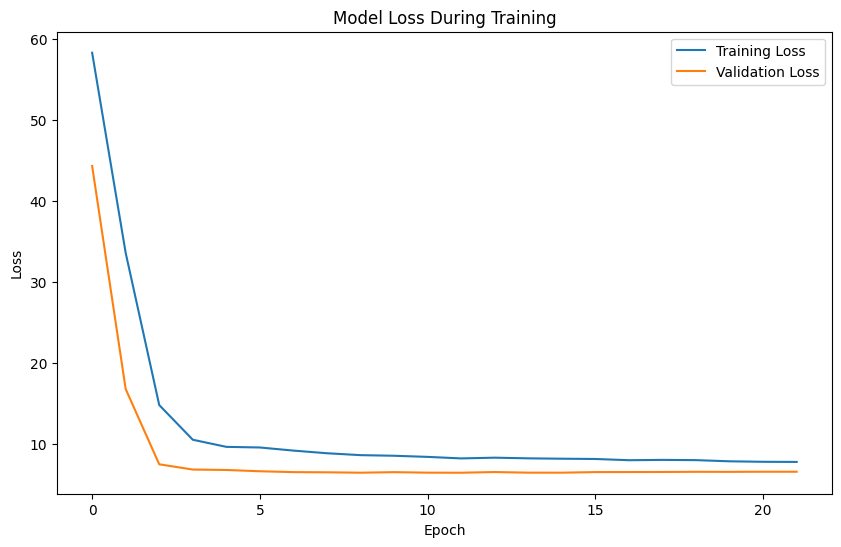

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
from datetime import datetime

# Generate our data
df = generate_synthetic_medical_data(10000)

def add_realistic_length_of_stay(df):
    """
    Add realistic length of stay based on established medical factors
    """
    # Fill NaN values in relevant columns first
    df_filled = df.copy()
    df_filled['adl_total_score'] = df_filled['adl_total_score'].fillna(df_filled['adl_total_score'].mean())
    df_filled['age'] = df_filled['age'].fillna(df_filled['age'].mean())

    # Base length of stay (log-normal distribution as typically seen in hospitals)
    los = np.random.lognormal(mean=1.5, sigma=0.4, size=len(df))

    # Adjust based on known factors
    # Age effect: longer stays for older patients
    age_effect = 0.02 * (df_filled['age'] - 65).clip(lower=0)

    # ADL effect: longer stays for lower ADL scores
    adl_effect = (24 - df_filled['adl_total_score']) * 0.15

    # Diagnosis effect
    diagnosis_multiplier = pd.Series(1.0, index=df.index)
    high_los_conditions = ['Stroke', 'COPD', 'Congestive Heart Failure']
    diagnosis_multiplier[df_filled['diagnosis'].isin(high_los_conditions)] = 1.4

    # Fall risk effect
    risk_multiplier = pd.Series(1.0, index=df.index)
    risk_multiplier[df_filled['fall_risk_assessment'] == 'High'] = 1.3

    # Combine effects
    los = los + age_effect + adl_effect
    los = los * diagnosis_multiplier * risk_multiplier

    # Add small random variation
    los += np.random.normal(0, 0.5, len(df))

    # Ensure reasonable bounds
    los = np.maximum(1, los)
    los = np.round(los, 1)

    return los

# Add realistic length of stay
df['length_of_stay'] = add_realistic_length_of_stay(df)

def prepare_features_nn(df):
    # Calculate days since admission
    df['days_since_admission'] = (pd.to_datetime('2024-01-01') -
                                pd.to_datetime(df['admission_date'])).dt.days

    # Convert falls_12mo to numeric properly
    df['falls_12mo_numeric'] = df['falls_12mo'].apply(lambda x: 5 if x == '5+' else int(x))

    # Select relevant features
    numeric_features = [
        'age',
        'physical_function',
        'falls_12mo_numeric',
        'adl_total_score',
        'days_since_admission'
    ]

    categorical_features = [
        'diagnosis',
        'living_situation',
        'typical_living_setting',
        'mobility_aid',
        'rehab_status',
        'fall_risk_assessment'
    ]

    # Create transformers with imputers
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return preprocessor, numeric_features, categorical_features

# Print initial NaN statistics
print("Initial NaN count per column:")
print(df.isna().sum())

# Prepare data
preprocessor, numeric_features, categorical_features = prepare_features_nn(df)
X = df[numeric_features + categorical_features]
y = df['length_of_stay']

# Use a more standard train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess features
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("\nShape of processed training data:", X_train_processed.shape)
print("Any NaN in processed training data:", np.isnan(X_train_processed).any())

# Create neural network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_processed.shape[1],)),
    BatchNormalization(),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1)
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

# Add early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions
y_pred = model.predict(X_test_processed).flatten()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Mean Absolute Error: {mae:.2f} days")
print(f"Root Mean Squared Error: {rmse:.2f} days")
print(f"R-squared Score: {r2:.3f}")

# Show sample predictions
print("\nSample Predictions (Actual vs Predicted):")
sample_indices = np.random.choice(len(y_test), 10, replace=False)
comparison = pd.DataFrame({
    'Actual': y_test.iloc[sample_indices],
    'Predicted': y_pred[sample_indices],
    'Difference': y_test.iloc[sample_indices] - y_pred[sample_indices]
})
print(comparison.round(2))

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

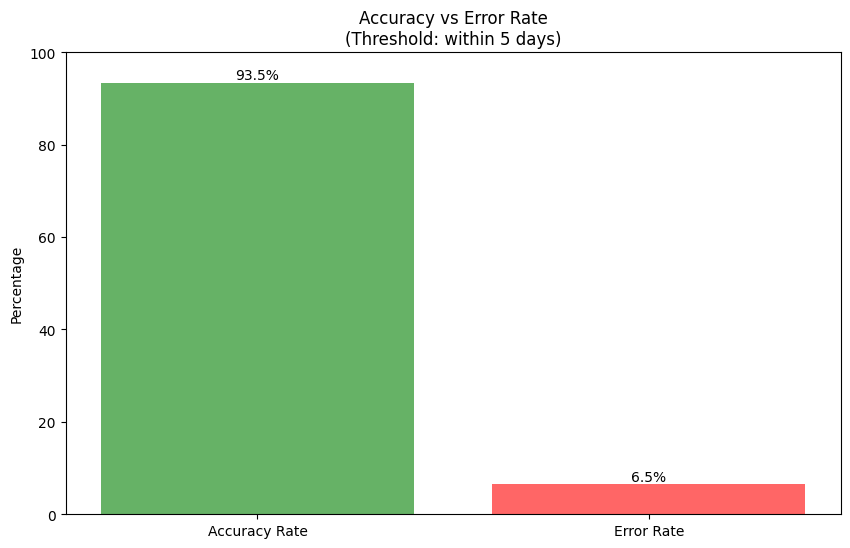

In [ ]:
# Calculate accuracy vs error rate (using 5-day threshold)
threshold = 5
errors = np.abs(y_test - y_pred)
accuracy_rate = (errors <= threshold).mean() * 100
error_rate = 100 - accuracy_rate

# Plot accuracy vs error rate
plt.figure(figsize=(10, 6))
bars = plt.bar(['Accuracy Rate', 'Error Rate'],
               [accuracy_rate, error_rate],
               color=['green', 'red'],
               alpha=0.6)

# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom')

plt.title(f'Accuracy vs Error Rate\n(Threshold: within {threshold} days)')
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.show()